<a href="https://colab.research.google.com/github/karu-bee/SIGNATE_Practice/blob/main/karu_bee/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import time
import os
from matplotlib import pyplot as plt
import random
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

%matplotlib inline
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


## ImageFolderを使用する

In [21]:
batch_size = 5
TRAIN_VAL_DATADIR = '/content/drive/MyDrive/train_data/'
TEST_DATADIR = '/content/drive/MyDrive/test_data/'

In [22]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ])}

In [23]:
data = torchvision.datasets.ImageFolder(root=TRAIN_VAL_DATADIR, transform=transform_dict["train"])

In [24]:
train_ratio = 0.8
train_size = int(train_ratio * len(data))
# int()で整数に。
val_size  = len(data) - train_size      
data_size  = {"train":train_size, "val":val_size}
#          =>{"train": 112,       "val": 28}
data_train, data_val = torch.utils.data.random_split(data, [train_size, val_size])

In [25]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(data_val,   batch_size=batch_size, shuffle=False)
dataloaders  = {"train":train_loader, "val":val_loader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


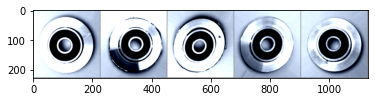

tensor(0) tensor(1) tensor(1) tensor(1) tensor(1)


In [26]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 訓練データをランダムに取得
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % labels[labels[j]] for j in range(5)))

In [27]:
for train in train_loader:
    print(train[0].shape)
    print(train[0].dtype)
    break

torch.Size([5, 3, 224, 224])
torch.float32


# 転移学習

In [28]:
#ネットワークalexnetの定義
#net = models.alexnet(pretrained=True)
net = models.vgg19(pretrained=True)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
net

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [29]:
#ネットワークのパラメータを凍結
for param in net.parameters():
    param.requires_grad = False
net = net.to(device)
#最終層を2クラス用に変更
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, 2).to(device)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [30]:
#最適化関数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [33]:
num_epochs = 15

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr：{learning_rate}' 
                       .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]["lr"]))
    #学習率調整
    lr_scheduler.step()
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/15], Loss: 1.6334, val_loss: 0.3658, val_acc: 0.8200, lr：0.01
Epoch [2/15], Loss: 2.5630, val_loss: 2.2154, val_acc: 0.6400, lr：0.01
Epoch [3/15], Loss: 2.1957, val_loss: 4.0463, val_acc: 0.6200, lr：0.01
Epoch [4/15], Loss: 3.0582, val_loss: 1.8121, val_acc: 0.7600, lr：0.01
Epoch [5/15], Loss: 2.3771, val_loss: 0.2938, val_acc: 0.9000, lr：0.01
Epoch [6/15], Loss: 2.1759, val_loss: 0.4059, val_acc: 0.8400, lr：0.01
Epoch [7/15], Loss: 2.2015, val_loss: 0.1748, val_acc: 0.9200, lr：0.01
Epoch [8/15], Loss: 1.8106, val_loss: 0.2401, val_acc: 0.9200, lr：0.01
Epoch [9/15], Loss: 1.6190, val_loss: 1.1688, val_acc: 0.8400, lr：0.01
Epoch [10/15], Loss: 2.1785, val_loss: 2.3792, val_acc: 0.6400, lr：0.01
Epoch [11/15], Loss: 2.3451, val_loss: 0.3528, val_acc: 0.8600, lr：0.001
Epoch [12/15], Loss: 2.2895, val_loss: 0.1960, val_acc: 0.9400, lr：0.001
Epoch [13/15], Loss: 1.6293, val_loss: 0.1098, val_acc: 0.9000, lr：0.001
Epoch [14/15], Loss: 1.4449, val_loss: 0.4088, val_acc: 0.8800, lr：0.0

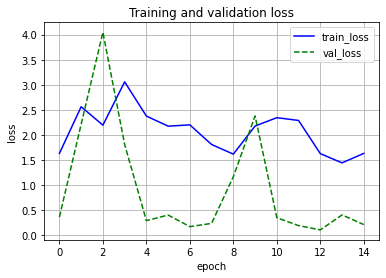

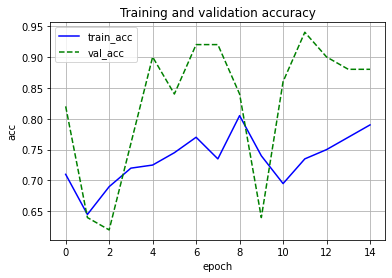

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [38]:
# ネットワークを保存する
torch.save(net.state_dict(), 'net.ckpt')

In [43]:
# ネットワークを読み込む
#net2 = net().to(device)
net.load_state_dict(torch.load('net.ckpt'))

<All keys matched successfully>

In [51]:
data_test = torchvision.datasets.ImageFolder(root=TEST_DATADIR, transform=transform_dict["test"])

In [57]:
test_loader   = torch.utils.data.DataLoader(data_test,   batch_size=batch_size, shuffle=False)

In [60]:
test_loss_list = []
test_acc_list = []
test_loss = 0
test_acc = 0
net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

In [61]:
print(f"avg_val_loss={avg_val_loss}, avg_val_acc={avg_val_acc}")

avg_val_loss=0.10806474494934076, avg_val_acc=0.44
